In [13]:
import sys
import random
import string
import matplotlib.pyplot as plt
import math
import os

from tqdm import tqdm
import decimal
from decimal import Decimal

decimal.getcontext().prec=500

In [23]:
MAIN_PATH = "arith-vis/"
FASTA_PATH = MAIN_PATH + "hbb_fasta/"
SAVE_PATH = MAIN_PATH + "visualizations/"

In [15]:
def remove_trailing_zeros(num):
    strnum = str(num)
    if num == 0:
        return(num)
    else:
        if strnum[len(strnum)-1] == "0":
            return remove_trailing_zeros(Decimal(strnum[:len(strnum)-1]))

        else:
            return(Decimal(strnum))

#calculates entropy given probability table (max entropy is 2*k, that is, a 2-bit encoding)
def calc_entropy(probs):
    entropy = 0
    for p in probs:
        if p!=0:
            entropy = entropy - p*Decimal(math.log2(p))
    return round(entropy, 8)


In [16]:
def open_FASTA(filename):
    file = open(filename, 'r')
    next(file)
    return file.read().replace("\n", "") 

In [17]:
# Function to convert decimal to binary  
def decimalToBinary(num, cutoff) : 
  
    binary = ""  
  
    # Fetch the integral part of 
    # decimal number  
    Integral = int(num)  
  
    # Fetch the fractional part  
    # decimal number  
    fractional = num - Integral 
  
    # Conversion of integral part to  
    # binary equivalent  
    while (Integral) : 
          
        rem = Integral % 2
  
        # Append 0 in binary  
        binary += str(rem);  
  
        Integral //= 2
      
    # Reverse string to get original 
    # binary equivalent  
    binary = binary[ : : -1]  
  
    # Append point before conversion  
    # of fractional part  
    binary += '.'
  
    # Conversion of fractional part 
    # to binary equivalent  
    done = False
    counter = 0
    while (not done) : 
        counter+=1
        # Find next bit in fraction  
        fractional *= 2
        fract_bit = int(fractional) 
  
        if (fract_bit == 1) : 
              
            fractional -= fract_bit  
            binary += '1'
              
        else : 
            binary += '0'
  
        if(fractional==0 or counter>cutoff):
            done = True
            #print(fractional, fract_bit)
            #print(counter)
  
    return binary  

In [18]:
def binary_vis(seq):
    x_values = []
    y_values = []
    running_y = 0
    for i in range(0, len(seq)):
        if seq[i]=='0':
            running_y-=1
        elif seq[i]=='1':
            running_y+=1
        x_values.append(i+0.5)
        y_values.append(running_y)
    return x_values, y_values

In [19]:
#returns nucleotide base given a number 1-4
def get_bp(i):
    s = ""
    if i==1:
        s = "A"
    elif i==2: 
        s = "T"
    elif i==3:
        s = "C"
    elif i==4:
        s = "G"
    return s

#recursively creates empty kmer frequency table given k 
def get_kftable(freq_table, k):
    if k==0:
        return freq_table
    else:
        new_freq_table = {}
        if len(freq_table) == 0:
            new_freq_table = {"A": 0, "T": 0, "C": 0, "G": 0}
        else:
            
            for key in freq_table:
                for i in range(1,5): #from 1-4
                    new_key = key + get_bp(i)
                    new_freq_table.update( {new_key : 0})
        return get_kftable(new_freq_table, k-1)

#counts the amount of kmers in a particular DNA sequence (kmers are counted with slide by default)
def count_kmers(seq, k, sliding=True):
    freq_table = {}
    
    freq_table = get_kftable(freq_table, k)      
    j = 0
    total = 0
    if sliding: 
        j = 1
        total = len(seq)-k+1
    else: 
        j = k
        total = Decimal(int(len(seq)/k))
                
    for i in range(0, len(seq)-k+1, j):
        #print(seq[i:i+k])
        if seq[i:i+k] in freq_table.keys():
            freq_table[seq[i:i+k]]+=1
            
    prev = Decimal(0)
    new = Decimal(0)
    probs = []
    for key in freq_table:
        probs.append(remove_trailing_zeros(round(Decimal(freq_table[key])/(total), 8)))
        new = prev + remove_trailing_zeros(round(Decimal(freq_table[key])/(total), 8))
        freq_table[key] = [prev, new]
        prev = new
    return freq_table, probs

def kmer_encode(encode_str, freq_table, k, sliding=True):
    # probability table
    
    #for key, value in sorted(freq_table.items()):
        #print(key, value)

    lower_bound = 0  # upper bound
    upper_bound = 1  # lower bound
    
    j = 0
    
    if sliding: 
        j = 1
    else: 
        j = k
        
    # go thru every symbol in the string
    for i in range(0, len(encode_str)-k+1, j):
        sym = encode_str[i:i+k]
        if sym in freq_table:
            curr_range = upper_bound - lower_bound  # current range
            upper_bound = remove_trailing_zeros(lower_bound + (curr_range * freq_table[sym][1]))   # upper_bound
            lower_bound = remove_trailing_zeros(lower_bound + (curr_range * freq_table[sym][0]))   # lower bound

    return lower_bound

In [20]:
filenames0 = os.listdir(FASTA_PATH)
filenames = []
for file in filenames0:
    if '.DS_Store' != file:
        filenames.append(file)
filenames.sort()

k = 3
SLIDING = True

for file in filenames:
    seq = open_FASTA(FASTA_PATH+file)
    freq_table = count_kmers(seq, k, SLIDING)[0] 
    encoded = kmer_encode(seq, freq_table, 3, SLIDING)
    
    entropy = calc_entropy(count_kmers(seq, 3, SLIDING)[1])
    print(file.split('.')[0], " - Entropy (BPS):", entropy, "Length of OG String:", len(seq), "Expected Length of Bitstring:", entropy*len(seq))
    bin_encoded = decimalToBinary(encoded, math.ceil(entropy*len(seq)))
    
    x_vals, y_vals = binary_vis(str(bin_encoded)[1:len(str(bin_encoded))])
    x_vals = [x/len(x_vals) for x in x_vals]
    plt.plot(x_vals, y_vals, color = 'black')

    # print(freq_table)
    
    save_filename= file.split('.')[0]+"_sliding_3mer"
    plt.savefig(SAVE_PATH+save_filename)
    plt.close()

alpaca_hbb  - Entropy (BPS): 5.82497594 Length of OG String: 1512 Expected Length of Bitstring: 8807.36362128
bat_hbb  - Entropy (BPS): 5.76415556 Length of OG String: 1594 Expected Length of Bitstring: 9188.06396264
chinchilla_hbb  - Entropy (BPS): 5.78328024 Length of OG String: 1352 Expected Length of Bitstring: 7818.99488448
cow_hbb  - Entropy (BPS): 5.80250822 Length of OG String: 1643 Expected Length of Bitstring: 9533.52100546
dog_hbb  - Entropy (BPS): 5.75479039 Length of OG String: 1360 Expected Length of Bitstring: 7826.51493040
goat_hbb  - Entropy (BPS): 5.80322531 Length of OG String: 1568 Expected Length of Bitstring: 9099.45728608
human_hbb  - Entropy (BPS): 5.74750343 Length of OG String: 1608 Expected Length of Bitstring: 9241.98551544
norwayrat_hbb  - Entropy (BPS): 5.71684891 Length of OG String: 1412 Expected Length of Bitstring: 8072.19066092
pelican_hbb  - Entropy (BPS): 5.76030685 Length of OG String: 1683 Expected Length of Bitstring: 9694.59642855
pig_hbb  - Ent

In [24]:
k = 3
SLIDING = True

file1 = "covid.fasta.txt"
file2 = "mers.fasta.txt"
file3 = "AT.fasta.txt"

seq1 = open_FASTA(GENOME_PATH+file1)
freq_table1 = count_kmers(seq1, k, SLIDING)[0] 
encoded1 = kmer_encode(seq1, freq_table1, 3, SLIDING)

seq2 = open_FASTA(GENOME_PATH+file2)
freq_table2 = count_kmers(seq2, k, SLIDING)[0] 
encoded2 = kmer_encode(seq2, freq_table2, 3, SLIDING)

seq3 = open_FASTA(GENOME_PATH+file3)
freq_table3 = count_kmers(seq3, k, SLIDING)[0] 
encoded3 = kmer_encode(seq3, freq_table3, 3, SLIDING)

entropy1 = calc_entropy(count_kmers(seq1, 3, SLIDING)[1])
entropy2 = calc_entropy(count_kmers(seq2, 3, SLIDING)[1])
entropy3 = calc_entropy(count_kmers(seq3, 3, SLIDING)[1])

print(file1.split('.')[0], " - Entropy (BPS):", entropy1, "Length of OG String:", len(seq1), "Expected Length of Bitstring:", entropy1*len(seq1))
print(file2.split('.')[0], " - Entropy (BPS):", entropy2, "Length of OG String:", len(seq2), "Expected Length of Bitstring:", entropy2*len(seq2))
print(file3.split('.')[0], " - Entropy (BPS):", entropy3, "Length of OG String:", len(seq3), "Expected Length of Bitstring:", entropy3*len(seq3))

bin_encoded1 = decimalToBinary(encoded1, math.ceil(entropy1*len(seq1)))
bin_encoded2 = decimalToBinary(encoded2, math.ceil(entropy2*len(seq2)))
bin_encoded3 = decimalToBinary(encoded3, math.ceil(entropy3*len(seq3)))

x_vals1, y_vals1 = binary_vis(str(bin_encoded1)[1:len(str(bin_encoded1))])
x_vals2, y_vals2 = binary_vis(str(bin_encoded2)[1:len(str(bin_encoded2))])
x_vals3, y_vals3 = binary_vis(str(bin_encoded3)[1:len(str(bin_encoded3))])

x_vals1 = [x/len(x_vals2) for x in x_vals1]
x_vals2 = [x/len(x_vals2) for x in x_vals2]
x_vals3 = [x/len(x_vals2) for x in x_vals3]

plt.plot(x_vals1, y_vals1, color = 'red')
plt.plot(x_vals2, y_vals2, color = 'green')
plt.plot(x_vals3, y_vals3, color = 'blue')

save_filename= "no_scale_3way-comparison"
plt.savefig(SAVE_PATH+save_filename)
plt.close()



covid  - Entropy (BPS): 5.80047300 Length of OG String: 29903 Expected Length of Bitstring: 173451.54411900
mers  - Entropy (BPS): 5.87481175 Length of OG String: 30119 Expected Length of Bitstring: 176943.45509825
AT  - Entropy (BPS): 1.00101732 Length of OG String: 30119 Expected Length of Bitstring: 30149.64066108


In [26]:
k = 3
SLIDING = True

file1 = "covid.fasta.txt"
file2 = "mers.fasta.txt"
file3 = "AT.fasta.txt"

seq1 = open_FASTA(GENOME_PATH+file1)
seq2 = open_FASTA(GENOME_PATH+file2)
seq3 = open_FASTA(GENOME_PATH+file3)

freq_table, probs = count_kmers(seq1+seq2+seq3, k, SLIDING)

encoded1 = kmer_encode(seq1, freq_table, 3, SLIDING)
encoded2 = kmer_encode(seq2, freq_table, 3, SLIDING)
encoded3 = kmer_encode(seq3, freq_table, 3, SLIDING)

entropy1 = calc_entropy(count_kmers(seq1, 3, SLIDING)[1])
entropy2 = calc_entropy(count_kmers(seq2, 3, SLIDING)[1])
entropy3 = calc_entropy(count_kmers(seq3, 3, SLIDING)[1])

# print(freq_table)

print(file1.split('.')[0], " - Entropy (BPS):", entropy1, "Length of OG String:", len(seq1), "Expected Length of Bitstring:", entropy1*len(seq1))
print(file2.split('.')[0], " - Entropy (BPS):", entropy2, "Length of OG String:", len(seq2), "Expected Length of Bitstring:", entropy2*len(seq2))
print(file3.split('.')[0], " - Entropy (BPS):", entropy3, "Length of OG String:", len(seq3), "Expected Length of Bitstring:", entropy3*len(seq3))

bin_encoded1 = decimalToBinary(encoded1, math.ceil(entropy1*len(seq1)))
bin_encoded2 = decimalToBinary(encoded2, math.ceil(entropy2*len(seq2)))
bin_encoded3 = decimalToBinary(encoded3, math.ceil(entropy3*len(seq3)))

x_vals1, y_vals1 = binary_vis(str(bin_encoded1)[1:len(str(bin_encoded1))])
x_vals2, y_vals2 = binary_vis(str(bin_encoded2)[1:len(str(bin_encoded2))])
x_vals3, y_vals3 = binary_vis(str(bin_encoded3)[1:len(str(bin_encoded3))])

#x_vals1 = [x/len(x_vals2) for x in x_vals1]
#x_vals2 = [x/len(x_vals2) for x in x_vals2]
#x_vals3 = [x/len(x_vals2) for x in x_vals3]

plt.plot(x_vals1, y_vals1, color = 'red')
plt.plot(x_vals2, y_vals2, color = 'green')
plt.plot(x_vals3, y_vals3, color = 'blue')

save_filename= "combined_freq_3way-comparison"
plt.savefig(SAVE_PATH+save_filename)
plt.close()


covid  - Entropy (BPS): 5.80047300 Length of OG String: 29903 Expected Length of Bitstring: 173451.54411900
mers  - Entropy (BPS): 5.87481175 Length of OG String: 30119 Expected Length of Bitstring: 176943.45509825
AT  - Entropy (BPS): 1.00101732 Length of OG String: 30119 Expected Length of Bitstring: 30149.64066108


In [27]:
k = 3
SLIDING = True

file1 = "covid.fasta.txt"
file2 = "mers.fasta.txt"
file3 = "AT.fasta.txt"

seq1 = open_FASTA(GENOME_PATH+file1)
seq2 = open_FASTA(GENOME_PATH+file2)
seq3 = open_FASTA(GENOME_PATH+file3)

freq_table, probs = count_kmers(seq1+seq2+seq3, k, SLIDING)
# freq_table, probs = count_kmers(seq3+seq2+seq1, k, SLIDING)
# print(freq_table, probs)

encoded1 = kmer_encode(seq1, freq_table, 3, SLIDING)
encoded2 = kmer_encode(seq2, freq_table, 3, SLIDING)
encoded3 = kmer_encode(seq3, freq_table, 3, SLIDING)

entropy1 = calc_entropy(count_kmers(seq1, 3, SLIDING)[1])
entropy2 = calc_entropy(count_kmers(seq2, 3, SLIDING)[1])
entropy3 = calc_entropy(count_kmers(seq3, 3, SLIDING)[1])

bin_encoded1 = decimalToBinary(encoded1, math.ceil(entropy1*len(seq1)))
bin_encoded2 = decimalToBinary(encoded2, math.ceil(entropy2*len(seq2)))
bin_encoded3 = decimalToBinary(encoded3, math.ceil(entropy3*len(seq3)))

x_vals1, y_vals1 = binary_vis(str(bin_encoded1)[1:len(str(bin_encoded1))])
x_vals2, y_vals2 = binary_vis(str(bin_encoded2)[1:len(str(bin_encoded2))])
x_vals3, y_vals3 = binary_vis(str(bin_encoded3)[1:len(str(bin_encoded3))])

plt.plot(x_vals1, y_vals1, color = 'red')
plt.plot(x_vals2, y_vals2, color = 'green')
plt.plot(x_vals3, y_vals3, color = 'blue')
plt.close()


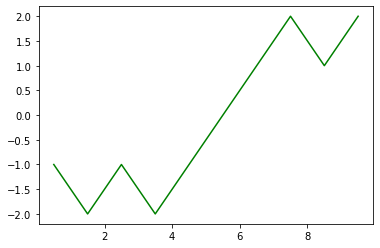

In [28]:
seq = "AATGGCGGC"
freq_table, probs = count_kmers(seq, 3, sliding=False)
encoded = kmer_encode(seq, freq_table, 3, sliding=False)
# print(encoded)
# print(freq_table)
entropy = calc_entropy(count_kmers(seq, 3, sliding=False)[1])
bin_encoded = decimalToBinary(encoded, math.ceil(entropy*len(seq)))
# print(bin_encoded)
x_vals, y_vals = binary_vis(str(bin_encoded)[1:len(str(bin_encoded))])
plt.plot(x_vals, y_vals, color = 'green')